In [1]:
import os
import json
import random
import numpy as np
import math
import torch
import gpytorch
import sys
import re
import statistics
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
SETTING_FILE_NAME = "setting_file.txt"
BIN_SIZE = 181
TEMPARETURE = 300.
KB_KCALPERMOL = 0.0019872041
KBT = KB_KCALPERMOL * TEMPARETURE
SPRING_CONSTANT = 200.0 * ((math.pi/180.0) ** 2)
SIGMA = 5
SIGMA_POW_2 = SIGMA ** 2
DATA_TRAIN_SPLIT = 3

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
def read_json_file(path):
    with open(path,'r') as f:
        return json.load(f)

def gauss(x, mean):
    _x = np.linalg.norm(np.array(x) - np.array(mean))
    return math.exp(-((_x ** 2) / (2 * (SIGMA_POW_2))))

def biased_energy(x, center):
    dx = np.linalg.norm(x - center)
    dx = dx - (math.trunc(dx / 360.0)) * 360.0
    return (SPRING_CONSTANT / KBT) * (dx ** 2)

def cal_delta_PMF(x_from, x_to, center, kde):
    tmp_PMF_to =  KBT * math.log(kde(x_to)) + biased_energy(x_to, center)
    tmp_PMF_from =  KBT * math.log(kde(x_from)) + biased_energy(x_from, center)
    return - (tmp_PMF_to - tmp_PMF_from)

def train(training_times, model, likelihood, optimizer, mll, train_x, train_y):
    for i in range(training_times):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1,
                                           training_times,
                                           loss.item()))
        optimizer.step()

In [5]:
setting_data = read_json_file(SETTING_FILE_NAME)

In [6]:
def add_train_data(from_x, train_x, train_y):
    now_x = [from_x]
    now_y = cal_delta_PMF(from_x, from_x + (1.0/DATA_TRAIN_SPLIT), angle, now_kde)
    train_x.append(now_x)
    train_y.append(now_y)

pred_x = []
for i in range(BIN_SIZE-1):
    for j in range(DATA_TRAIN_SPLIT):
        pred_x.append([i+j*(1.0/DATA_TRAIN_SPLIT)])
        
train_x = []
train_y = []
for angle in range(BIN_SIZE):
    for filePath in setting_data["outputFiles"]["{}".format(angle)]:
        with open(filePath) as file:
            rowData = np.array([str.strip().split() for str in file.readlines()], dtype = 'float')[:, 1]
            now_kde = gaussian_kde(rowData.T)

            tmp_x = np.linspace(angle - 5, angle + 5 - (1.0/DATA_TRAIN_SPLIT), 35)
            for i in range(len(tmp_x) - 1):
                add_train_data(tmp_x[i], train_x, train_y)

In [7]:
train_x = torch.Tensor(np.array(train_x))
train_y = torch.Tensor(np.array(train_y))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
train(50, model, likelihood, optimizer, mll, train_x, train_y)

Iter 1/50 - Loss: 0.824
Iter 2/50 - Loss: 0.788
Iter 3/50 - Loss: 0.742
Iter 4/50 - Loss: 0.706
Iter 5/50 - Loss: 0.666
Iter 6/50 - Loss: 0.626
Iter 7/50 - Loss: 0.580
Iter 8/50 - Loss: 0.540
Iter 9/50 - Loss: 0.493
Iter 10/50 - Loss: 0.450
Iter 11/50 - Loss: 0.407
Iter 12/50 - Loss: 0.368
Iter 13/50 - Loss: 0.315
Iter 14/50 - Loss: 0.275
Iter 15/50 - Loss: 0.225
Iter 16/50 - Loss: 0.179
Iter 17/50 - Loss: 0.140
Iter 18/50 - Loss: 0.091
Iter 19/50 - Loss: 0.046
Iter 20/50 - Loss: 0.003
Iter 21/50 - Loss: -0.048
Iter 22/50 - Loss: -0.090
Iter 23/50 - Loss: -0.136
Iter 24/50 - Loss: -0.184
Iter 25/50 - Loss: -0.233
Iter 26/50 - Loss: -0.272
Iter 27/50 - Loss: -0.313
Iter 28/50 - Loss: -0.361
Iter 29/50 - Loss: -0.400
Iter 30/50 - Loss: -0.442
Iter 31/50 - Loss: -0.486
Iter 32/50 - Loss: -0.525
Iter 33/50 - Loss: -0.563
Iter 34/50 - Loss: -0.596
Iter 35/50 - Loss: -0.633
Iter 36/50 - Loss: -0.666
Iter 37/50 - Loss: -0.697
Iter 38/50 - Loss: -0.726
Iter 39/50 - Loss: -0.754
Iter 40/50 - Lo

In [8]:
model.eval()
likelihood.eval()

plot_x = range(BIN_SIZE)
freeEnegy_y = [0 for i in range(BIN_SIZE)]
variance_y = [0 for i in range(BIN_SIZE)]
variance_y_cou = [0 for i in range(BIN_SIZE)]
variance_sum_y = [0 for i in range(BIN_SIZE)]

pred_y = likelihood(model(torch.Tensor(pred_x)))
grad = pred_y.mean
lower, upper = pred_y.confidence_region()

for i in range(len(plot_x) - 1):
    nowEnegy = 0
    nowVariance = 0

    for j in range(DATA_TRAIN_SPLIT):
        id = i * DATA_TRAIN_SPLIT + j
        diff_variance = (upper[id] - lower[id]) / 2
        nowEnegy += grad[id]
        nowVariance += diff_variance ** 2

        if (j / DATA_TRAIN_SPLIT) < 0.5:
            variance_y[i] += diff_variance ** 2
            variance_y_cou[i] += 1
        else:
            variance_y[i+1] += diff_variance ** 2
            variance_y_cou[i+1] += 1

    freeEnegy_y[i+1] = freeEnegy_y[i] + nowEnegy.item()
    variance_sum_y[i+1] = variance_sum_y[i] + nowVariance.item()

for i in range(len(variance_sum_y)):
    variance_sum_y[i] = math.sqrt(variance_sum_y[i])
    variance_y[i] /= max(1, variance_y_cou[i])
    #variance_y[i] =  variance_y[i].item()

variance_upper_y = (np.array(freeEnegy_y) + np.array(variance_sum_y)).tolist()
variance_lower_y = (np.array(freeEnegy_y) - np.array(variance_sum_y)).tolist()

In [9]:
def wham_analyze():
    with open("wham_from_cycle_data.txt") as file:
        return np.array([str.strip().split() for str in file.readlines()], dtype = 'float')[:, 1]

In [10]:
wham_y = wham_analyze()

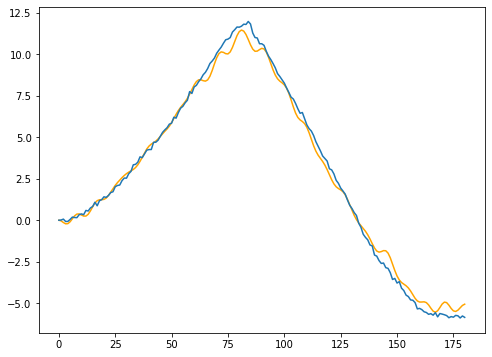

In [11]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(plot_x, freeEnegy_y, color="orange")
ax.plot(plot_x, wham_y, )

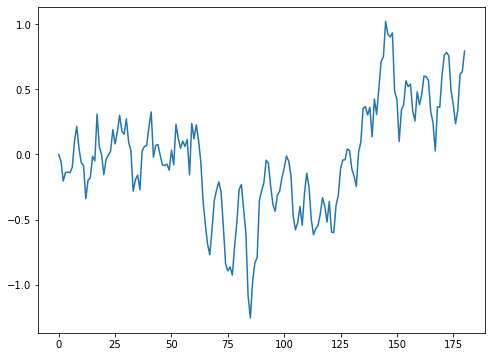

In [12]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(plot_x, freeEnegy_y - wham_y)

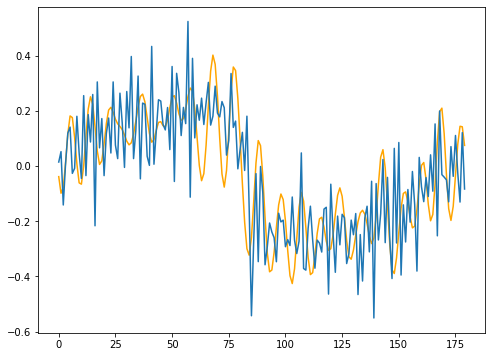

In [13]:
gauss_diff = np.array(freeEnegy_y[1:]) - np.array(freeEnegy_y[:-1])
wham_diff = np.array(wham_y[1:]) - np.array(wham_y[:-1])
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(plot_x[:-1], gauss_diff, color="orange")
ax.plot(plot_x[:-1], wham_diff)

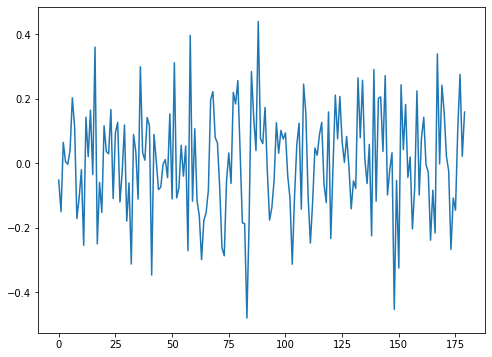

In [14]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(plot_x[:-1], gauss_diff - wham_diff)

In [15]:
sum = 0;

for i in range(BIN_SIZE):
    sum += (freeEnegy_y[i] - wham_y[i]) ** 2

print(sum / BIN_SIZE)

0.18012290396332228
